In [ ]:
# ..... compare CHD genes, LoF with cross-species coexp cons ..... #

In [2]:
library(dplyr)
library(corrplot)
library(ggplot2)
library(viridis)
my_palette = viridis::inferno(8)

In [3]:
v1 = paste0('chicken_', c('stage23', 'stage28', 'stage32'))  # chicken
v2 = paste0('turtle_', c('stage14', 'stage17', 'stage21'))  # turtle
v3 = paste0('lizard_', c('stage9', 'stage13', 'stage16'))  # lizard

In [22]:
# get list of species pairs
list1 = c(v1, v2, v3)
combos = cbind(combn(v1, 2), combn(v2, 2), combn(v3, 2), rbind(rep(v1, each = 3), rep(v2, 3)),
               rbind(rep(v1, each = 3), rep(v3, 3)), rbind(rep(v2, each = 3), rep(v3, 3)))
combos

# get coexp cons mat per gene
get_corrmat <- function(df, genename, spestages){
    temp = df[df$gene==genename,]
    mat = matrix(NA, nrow = 9, ncol = 9)
    
    for(ii in 1:dim(temp)[1]){
        id1 = match(temp$stage1[ii], spestages)
        id2 = match(temp$stage2[ii], spestages)
        mat[id1, id2] = temp$sc[ii]
        mat[id2, id1] = temp$sc[ii]
    }
    rownames(mat) = spestages
    colnames(mat) = spestages
    return(mat)
}

[,1]            [,2]            [,3]            [,4]          
[1,] chicken_stage23 chicken_stage23 chicken_stage28 turtle_stage14
[2,] chicken_stage28 chicken_stage32 chicken_stage32 turtle_stage17
     [,5]           [,6]           [,7]           [,8]           [,9]          
[1,] turtle_stage14 turtle_stage17 lizard_stage9  lizard_stage9  lizard_stage13
[2,] turtle_stage21 turtle_stage21 lizard_stage13 lizard_stage16 lizard_stage16
     [,10]           [,11] [,12]           [,13]          [,14]         
[1,] chicken_stage23 ⋯     chicken_stage32 turtle_stage14 turtle_stage14
[2,] turtle_stage14  ⋯     lizard_stage16  lizard_stage9  lizard_stage13
     [,15]          [,16]          [,17]          [,18]          [,19]         
[1,] turtle_stage14 turtle_stage17 turtle_stage17 turtle_stage17 turtle_stage21
[2,] lizard_stage16 lizard_stage9  lizard_stage13 lizard_stage16 lizard_stage9 
     [,20]          [,21]         
[1,] turtle_stage21 turtle_stage21
[2,] lizard_stage13 lizard_stage16

In [6]:
# get full df of coexp cons scores
newdf = c()
for(ii in 1:dim(combos)[2]){
    s1 = combos[1,ii]
    s2 = combos[2,ii]
    temp = read.delim(paste0('~/septation/', s1, '_', s2, '_pseudobulk_coexp_cons.csv'), sep = ',')
    temp$stage1 = s1
    temp$stage2 = s2
    temp$gene = temp[,1]
    newdf = rbind(newdf, temp[,c('stage1', 'stage2', 'gene', 'sc')])
}

In [86]:
unique(newdf$gene[grep('TBX', newdf$gene)])

[1] "TBX19"  "TBXAS1" "TBX15"  "TBX20"  "TBX18"  "TBXT"   "TBX22"  "TBX5"  
 [9] "TBX3"   "TBX1"   "TBX6"   "TBX4"   "TBX2"   "TBXA2R" "TBX21"  "TBX10"

Warning message in corrplot(corrmat, method = "color", is.corr = F, col = my_palette[3:8], :
“col.lim interval too wide, please set a suitable value”


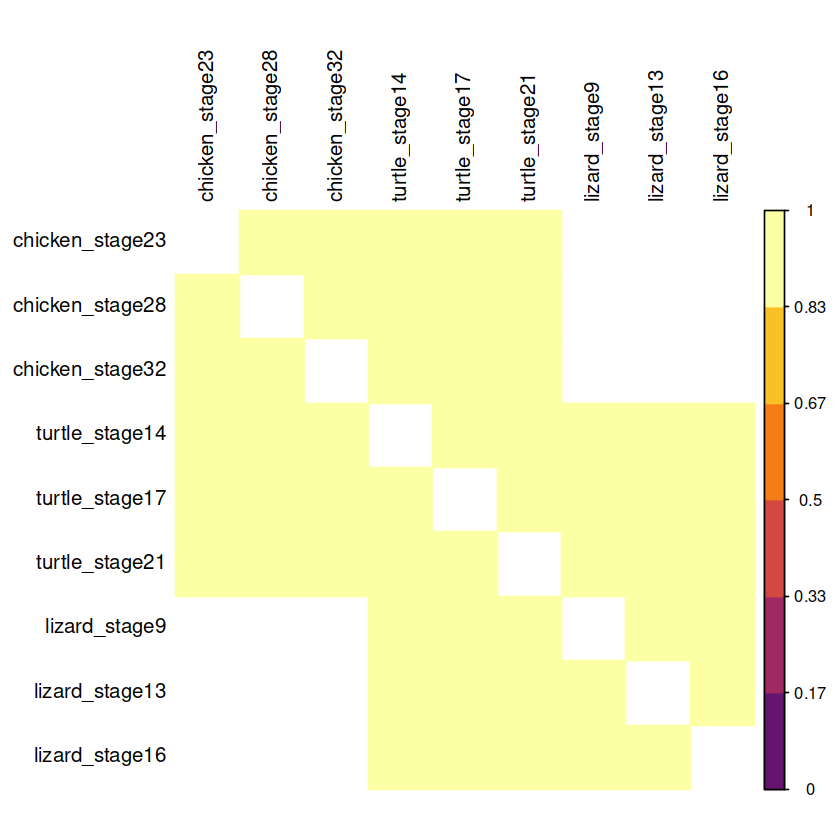

In [27]:
# GLI3, NOTCH1, CHD7; disease - DOLK, SCN1A, CALR, FZD5, GJA1, FOXF1
# not conserved across species - THBS1, ANKRD1
currgene = 'ACTC1'
corrmat = get_corrmat(newdf, currgene, list1)
# png(paste0('aa-crx-', currgene, '.png'), width = 5, height = 5, res = 300, units = 'in')
corrplot(corrmat, method = 'color', is.corr = F, col = my_palette[3:8], col.lim = c(0,1),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()

In [8]:
genelist = unique(newdf$gene)
genedf = data.frame(gene = genelist, score = NA)
for(ii in 1:length(genelist)){
    vec = newdf$sc[newdf$gene==genelist[ii]]
    genedf$score[ii] = mean(vec, na.rm = T)
}
genedf[1:3,]

In [45]:
# save
write.table(genedf, file = 'disease/pseudobulk_scores.csv', sep = ',', row.names = F, col.names = T,
           quote = F)

In [9]:
# gradation between chicken, turtle and lizard?
newdf$species1 = sub('\\_.*', '', newdf[,1])
newdf$species2 = sub('\\_.*', '', newdf[,2])
newdf[1,]

stage1          stage2          gene  sc        species1 species2
1 chicken_stage23 chicken_stage28 SPRY2 0.9777431 chicken  chicken

In [10]:
t1 = newdf[newdf$species1==newdf$species2 & newdf$species1=='chicken',]
t11 = t1 %>% group_by(gene) %>% summarise(within_score = mean(sc, na.rm = T))
t2 = newdf[newdf$species1!=newdf$species2 & newdf$species1=='chicken',]
t22 = t2 %>% group_by(gene) %>% summarise(across_score = mean(sc, na.rm = T))
t33 = merge(t11, t22)
t33 <- t33[!is.na(t33$within_score) & !is.na(t33$across_score),]
t33[1:2,]

gene   within_score across_score
1 A1CF   0.8597358    0.8079614   
2 A4GALT 0.9052981    0.7832002

In [11]:
divgenes = t33$gene[t33$within_score>0.9 & t33$across_score<0.6]
divgenes[1:20]

[1] "AATK"     "ABCC5"    "ABCC6"    "ABCD4"    "ABCG1"    "ABHD17B" 
 [7] "ACSS2"    "ADAMTS10" "ADAP2"    "ADAT1"    "ADCY6"    "ADGRV1"  
[13] "ADK"      "ADORA2A"  "AKAP10"   "ALDH7A1"  "AMDHD1"   "AMN"     
[19] "AMOTL2"   "AMPD3"

In [62]:
source('gene_set_enrichment.R')
ginfo = read.delim('/data/CoCoCoNet/geneInfo/human_info.csv', sep = ',')
divgenes2 = ginfo$NetworkIDs[match(divgenes, ginfo$GeneSymbol)]
divgenes2 = divgenes2[!is.na(divgenes2)]
gse = gene_set_enrichment(divgenes2, 'human')

In [63]:
head(gse)

GO_term    description                                              
GO:1901292 GO:1901292 nucleoside phosphate catabolic process                   
GO:0009166 GO:0009166 nucleotide catabolic process                             
GO:0034404 GO:0034404 nucleobase-containing small molecule biosynthetic process
GO:0019637 GO:0019637 organophosphate metabolic process                        
GO:0046434 GO:0046434 organophosphate catabolic process                        
GO:0009156 GO:0009156 ribonucleoside monophosphate biosynthetic process        
           N_sample N_univ pvals        adj_pvals   sig  
GO:1901292 11        76    7.669102e-07 0.006894523 FALSE
GO:0009166 10        70    2.760461e-06 0.010808028 FALSE
GO:0034404 12       110    5.209772e-06 0.010808028 FALSE
GO:0019637 44       982    5.807940e-06 0.010808028 FALSE
GO:0046434 14       151    6.011139e-06 0.010808028 FALSE
GO:0009156  7        34    7.313253e-06 0.010957690 FALSE

In [64]:
gse$description[gse$adj_pvals<0.05]

[1] "nucleoside phosphate catabolic process"                   
[2] "nucleotide catabolic process"                             
[3] "nucleobase-containing small molecule biosynthetic process"
[4] "organophosphate metabolic process"                        
[5] "organophosphate catabolic process"                        
[6] "ribonucleoside monophosphate biosynthetic process"        
[7] "ammonium ion metabolic process"                           
[8] "ribonucleoside monophosphate metabolic process"